# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1. Define the model class.

In [2]:
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(no_features, no_hidden[0]), # input-->hidden layer 1
            nn.ReLU(), # ReLU
            nn.Dropout(p=0.2), # dorupout of 0.2
            nn.Linear(no_hidden[0], no_hidden[1]), # hidden layer 1-->hidden layer 2
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden[1], no_hidden[2]), # hidden layer 2-->hidden layer 3
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden[2], no_labels), # hidden layer 3-->output
            nn.Sigmoid()
        )
    
    # YOUR CODE HERE
    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits

#### Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

1. Split the dataset and do preprocessing.

In [3]:
from common_utils import split_dataset, preprocess_dataset

def preprocess(df):
    # YOUR CODE HERE
    columns_to_drop = ['filename', 'label']
    X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # Divide the dataset into a 70:30 ratio for training and testing AND set random state for repeatability
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test) # scale features, labels are simply 0's and 1's no furtherscaling required
    
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

print(df['label'].value_counts())

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

label
pos    6202
neg    5855
Name: count, dtype: int64


#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 256**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [4]:
class CustomDataset(Dataset):
  # YOUR CODE HERE
  def __init__(self, X, y):
    self.X =torch.tensor(X, dtype=torch.float)
    self.y =torch.tensor(y)
    
  def __len__(self):
    return len(self.y)

  def __getitem__(self,idx):
    return self.X[idx], self.y[idx]

def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    # YOUR CODE HERE
    train_data = CustomDataset(X_train_scaled, y_train)
    test_data = CustomDataset(X_test_scaled, y_test)

    train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=256, shuffle=True)
    
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

2. Next, define the model, optimizer and loss function.

In [5]:
# YOUR CODE HERE
no_inputs = X_train_scaled.shape[1]
model = MLP(no_inputs, [128, 128, 128], 1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

In [6]:
# Early stopper
from common_utils import EarlyStopper

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [7]:
# YOUR CODE HERE
early_stopper = EarlyStopper(patience=3, min_delta=0)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred.flatten(), y.float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (len(pred) - torch.sum(torch.not_equal(pred.flatten() > 0.5, torch.tensor(y))))
    
    train_loss /= num_batches
    train_correct_accuracy = (train_correct.item()/size)

    return train_loss, train_correct_accuracy

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred.flatten(), y.float()).item()
            test_correct += (len(pred) - torch.sum(torch.not_equal(pred.flatten() > 0.5, torch.tensor(y))))

    test_loss /= num_batches
    test_correct_accuracy = (test_correct/size)
    
    return test_loss, test_correct_accuracy

train_loss_list, train_correct_list = [], []
test_loss_list, test_correct_list = [], []
epochs = 100
for t in range(epochs):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)
    
    train_loss_list.append(train_loss)
    train_correct_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_correct_list.append(test_correct)
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    if early_stopper.early_stop(test_loss): 
        print("Done!")
        break

C:\Users\micha\AppData\Local\Temp\ipykernel_25700\3745185851.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_correct += (len(pred) - torch.sum(torch.not_equal(pred.flatten() > 0.5, torch.tensor(y))))
C:\Users\micha\AppData\Local\Temp\ipykernel_25700\3745185851.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_correct += (len(pred) - torch.sum(torch.not_equal(pred.flatten() > 0.5, torch.tensor(y))))


Epoch 1: Train_accuracy: 53.48%, Train_loss: 0.687970, Test_accuracy: 56.38%, Test_loss: 0.684445
Epoch 2: Train_accuracy: 58.32%, Train_loss: 0.674815, Test_accuracy: 57.66%, Test_loss: 0.676691
Epoch 3: Train_accuracy: 60.84%, Train_loss: 0.657509, Test_accuracy: 60.34%, Test_loss: 0.656677
Epoch 4: Train_accuracy: 62.21%, Train_loss: 0.648382, Test_accuracy: 61.91%, Test_loss: 0.660923
Epoch 5: Train_accuracy: 64.11%, Train_loss: 0.631687, Test_accuracy: 62.24%, Test_loss: 0.652428
Epoch 6: Train_accuracy: 65.35%, Train_loss: 0.620350, Test_accuracy: 63.71%, Test_loss: 0.641633
Epoch 7: Train_accuracy: 66.94%, Train_loss: 0.606315, Test_accuracy: 64.01%, Test_loss: 0.637343
Epoch 8: Train_accuracy: 68.87%, Train_loss: 0.586016, Test_accuracy: 63.32%, Test_loss: 0.645657
Epoch 9: Train_accuracy: 69.45%, Train_loss: 0.576724, Test_accuracy: 64.73%, Test_loss: 0.633934
Epoch 10: Train_accuracy: 69.94%, Train_loss: 0.562696, Test_accuracy: 65.40%, Test_loss: 0.627371
Epoch 11: Train_acc

#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


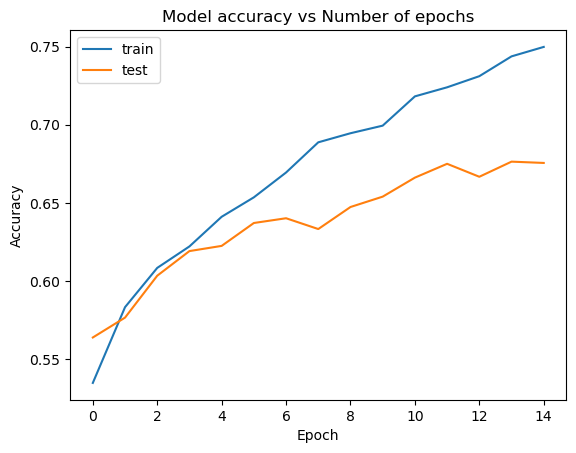

In [8]:
# YOUR CODE HERE
plt.figure()
plt.plot(train_correct_list)
plt.plot(test_correct_list)
plt.title('Model accuracy vs Number of epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])


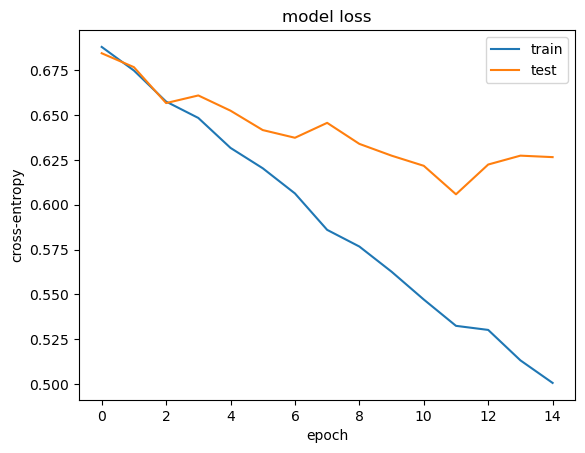

In [9]:
plt.figure()
plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.title('model loss')
plt.ylabel('cross-entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

2. Comment on line plots.

* For accuracy, while both train and test plots do show increase, the rate at which test accuracy increases is much slower compared to the train accuracy. 
* For the loss graph, the train loss decreased considerably faster compared to the test loss. In fact, the test loss shows signs of increasing back up by the last few epochs. 
* These trends indicate that overfitting was starting to occur. 

In [10]:
# YOUR CODE HERE
answer = "For accuracy, while both train and test plots do show increase, the rate at which test accuracy increases is much slower compared to the train accuracy. \n\
    For the loss graph, the train loss decreased considerably faster compared to the test loss. In fact, the test loss shows signs of increasing back up by the last few epochs. \n\
    These trends indicate that overfitting was starting to occur."
    
print("Answer:", answer)

Answer: For accuracy, while both train and test plots do show increase, the rate at which test accuracy increases is much slower compared to the train accuracy. 
    For the loss graph, the train loss decreased considerably faster compared to the test loss. In fact, the test loss shows signs of increasing back up by the last few epochs. 
    These trends indicate that overfitting was starting to occur.
